# Test finding conserved quantities in simple integrable models 
E.g. harmonic oscillator, Kepler, Neumann

## Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfe = tf.contrib.eager
import tensorflow_probability as tfp
tfd = tfp.distributions
import sys
sys.path.append("../")

#from IPython import display
#import imageio
#import glob
#import os

In [2]:
from models import *
from hamiltonians import harmonic_oscillator, kepler, parameterized_neumann
from utils import join_q_p, BaseDistributionNormal, BaseDistributionActionAngle, BaseDistributionIntegralsOfMotion
from utils import visualize_chain_bijector, extract_q_p, join_q_p, is_symplectic, normsq_nobatch
from losses import make_loss

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()

In [4]:
tf.set_random_seed(0)

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': kepler, #parameterized_neumann([.1,.2,.3]),
    'd': 3,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 128,    # Mini batch size 
    'num_bijectors': 6,   # Number of bijectors
    'train_iters': int(1e5), # Number of training iterations
    'log_dir' : "/tmp/log/im_tests/kepler_2/",
    'infinite_batch': True,
    'visualize': True}   

Define the model as sequence of a symplectic transformation T 

In [7]:
# Map the first pair psi, F to oscillator coordinates

# T = Chain([OscillatorFlow(first_only=True)] + 
#           [SymplecticAdditiveCoupling(shift_model=MLP()) if i % 2 == 0 
#            else LinearSymplecticTwoByTwo() 
#            for i in range(settings['num_bijectors'])])

T = Chain([SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh)) if i % 2 == 0 
           else LinearSymplecticTwoByTwo() 
           for i in range(settings['num_bijectors'])])

# T = HamiltonianFlow( MLPHamiltonian(), initial_t=0., final_t=1., num_steps=100 ) 

# class myf(tf.keras.Model):
#     def __init__(self):
#         super(myf, self).__init__()
#         d = 512
#         activation = tf.nn.softplus
#         self.dense1 = tf.keras.layers.Dense(d, activation=activation)
#         self.dense2 = tf.keras.layers.Dense(1, activation=activation)
    
#     def call(self, z):
#         z_shape = tf.shape(z)
#         z = tf.exp( self.dense2( self.dense1(tf.layers.flatten(z)) ) )
#         return tf.reshape(z, z_shape)
    
#     def inverse(self, z):
#         z_shape = tf.shape(z)
#         z = tf.exp( - self.dense2( self.dense1(tf.layers.flatten(z)) ) )
#         return tf.reshape(z, z_shape)    
    
# T = Chain([NonLinearSqueezing(myf()),
#            SymplecticAdditiveCoupling(shift_model=MLP()),
#            LinearSymplecticTwoByTwo(),
#            NonLinearSqueezing(myf()),
#            SymplecticAdditiveCoupling(shift_model=MLP()),
#            LinearSymplecticTwoByTwo() ])

Data and loss

In [8]:
with tf.name_scope("sampler"):    
    sh = [settings['d'], settings['num_particles'], 2]
    # Take cube of side scale
    scale = 10.
    sampler = tfd.Independent(tfd.Uniform(low=0. * tf.ones(sh, DTYPE),
                                          high=scale * tf.ones(sh, DTYPE)),
                              reinterpreted_batch_ndims=len(sh))
    z = sampler.sample(settings['batch_size'])
    if not settings['infinite_batch']:
        # Fixed batch. Every iteration gets exactly the same data
        z = tf.constant(sess.run(z)) 

loss = make_loss(settings, T, z, "K_equal_F1_loss")

## Training options

In [9]:
with tf.name_scope("train"):    
    step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)   
    starter_learning_rate = 0.001
    min_learning_rate = 1e-7
    learning_rate = tf.train.exponential_decay(starter_learning_rate, step,
                                               20000, 0.5, staircase=True)
    learning_rate = tf.maximum(learning_rate, min_learning_rate) # clip
    optimiser = tf.train.AdamOptimizer(learning_rate)
    gradients = optimiser.compute_gradients(loss=loss)
    if settings['visualize']:
        for gradient, variable in gradients:
            tf.summary.scalar("gradients/" + variable.name.replace(':','_'), tf.norm(gradient))
            tf.summary.scalar("variable/" + variable.name.replace(':','_'), tf.norm(variable))
    train_op = optimiser.apply_gradients(gradients, global_step=step)

## Train

In [16]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler_2/model.ckpt-88799
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 88799 into /tmp/log/im_tests/kepler_2/model.ckpt.
INFO:tensorflow:global_step/sec: 170.017
INFO:tensorflow:global_step/sec: 348.978
INFO:tensorflow:global_step/sec: 218.761
INFO:tensorflow:global_step/sec: 184.307
INFO:tensorflow:global_step/sec: 231.921
INFO:tensorflow:global_step/sec: 178.705
INFO:tensorflow:global_step/sec: 281.96
INFO:tensorflow:global_step/sec: 249.226
INFO:tensorflow:global_step/sec: 254.271
INFO:tensorflow:global_step/sec: 248.596
INFO:tensorflow:global_step/sec: 267.539
INFO:tensorflow:global_step/sec: 235.687
INFO:tensorflow:global_step/sec: 315.148
INFO:tensorflow:global_step/sec: 297.928
INFO:tensorflow:global_step/sec: 310.214
INFO:tensorflow:global_step/sec: 338.869
INFO:t

KeyboardInterrupt: 

In [17]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler_2/model.ckpt-106191


In [19]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  0.00078132283


In [24]:
is_symplectic( T, tf.random_normal([1,settings['d'],settings['num_particles'],2]), sess=sess, rtol=1e-05, atol=1e-04 )

True

### Visualize after training

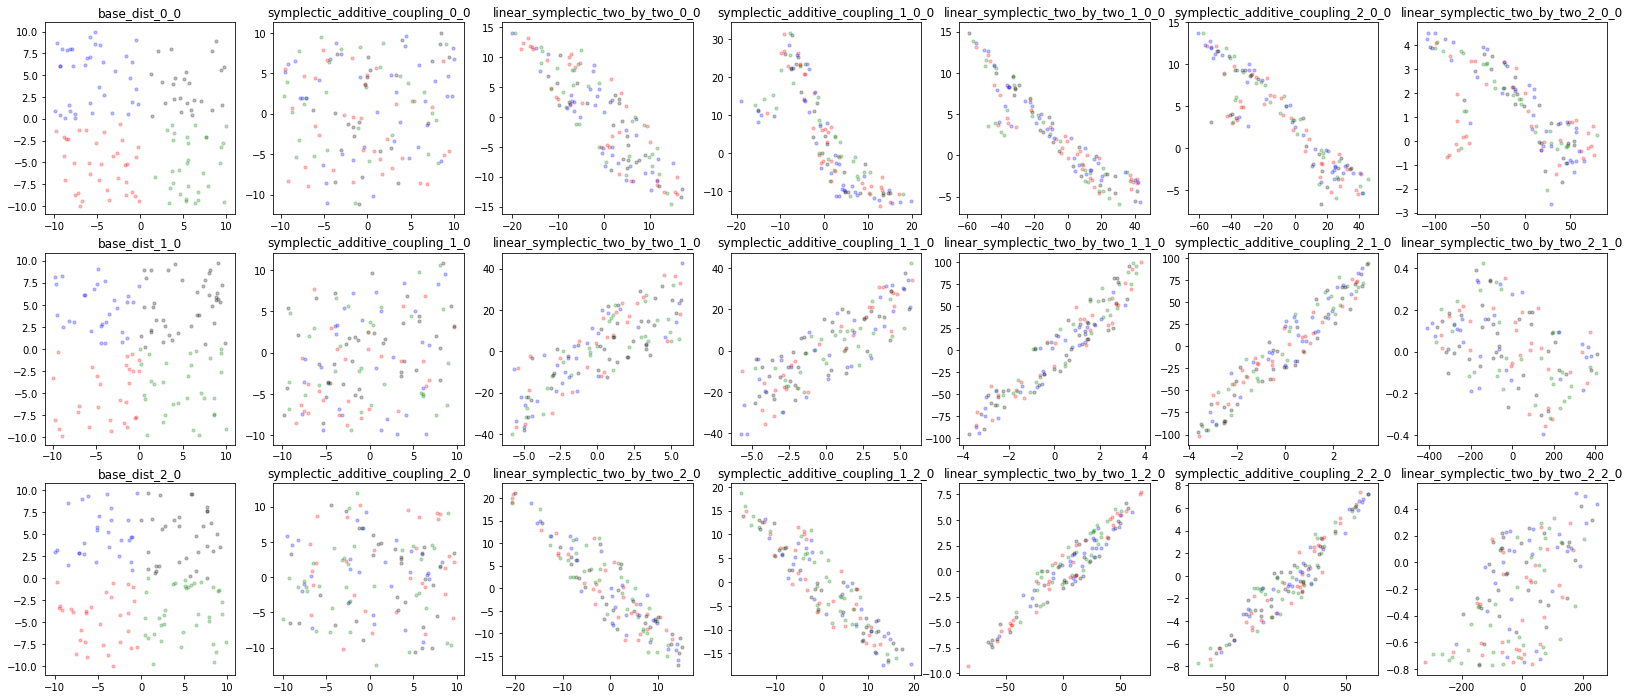

In [25]:
zz = tf.random_uniform([128,3,1,2],minval=-10,maxval=10)
visualize_chain_bijector(T, zz, sess=sess)
#visualize_chain_bijector(T, z, sess=sess)

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [27]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
x0 = sess.run( sampler.sample(1) * 1/scale )
print(x0)
#x0 = tf.reshape([1.,0.2,1.,0.3,1.,0.4],[1,3,1,2])

[[[[0.13735282 0.06811118]]

  [[0.84217346 0.41552028]]

  [[0.837504   0.5293603 ]]]]


In [28]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

Visualize: the transformed trajectories

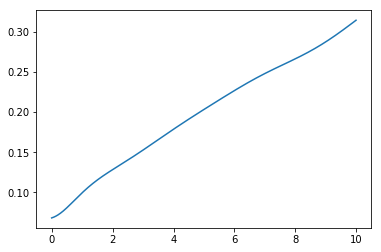

In [33]:
ts = np.arange(0.,10.,.01)
# rhotraj = np.sum( qtraj**2 + ptraj**2 , (1,2,3) )
# plt.plot(ts, rhotraj)

plt.plot(ts, ptraj[:,0,0,0])

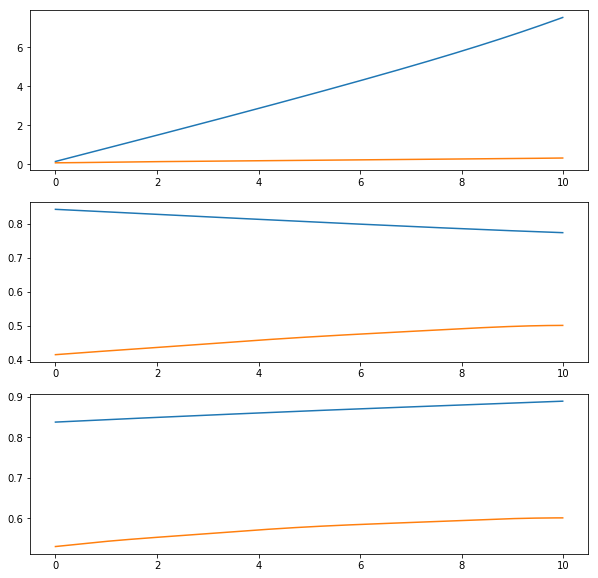

In [31]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, qtraj[:,d,n,0])
        plt.plot(ts, ptraj[:,d,n,0])
        #plt.gca().set_aspect('equal', adjustable='box')

Almost there...

TODO: Trajectories of original Hamiltonian

## Conclusions

For the radii minimization loss, the model learns to set $K$ to zero within the region of sampling. This is in general not possible with a symplectic transformation - think about the case of oscillators and trying to set the Hamiltonian in the action-angle variables to zero. In fact it is possible with a time dependent canonical transformation like in Hamilton-Jacobi eq, where Hamilton principal function is its generating function (see Goldstein) but we will not consider it here.

Instead the transformation to $K=F_1$ makes sense and occurs when one solves time-independent Hamiltonian from the reduced Hamilton-Jacobi equation, and Hamilton characteristic function is its generating function (see Goldstein)

TODO: update below

In [93]:
# Use HamiltonianFlow as integrator of Hamiltonian

integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition 
#x0 = sess.run( T( sampler.sample(1) ) )
#print(x0)
x0 = tf.reshape([.1, 0.2, .2, 0.2, .3, 0.2] ,[1,3,1,2])
q0,p0 = extract_q_p(x0)
print(q0.eval(), p0.eval())

[[[[0.1]]

  [[0.2]]

  [[0.3]]]] [[[[0.2]]

  [[0.2]]

  [[0.2]]]]


In [94]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
xtraj, ytraj = extract_q_p( traj )

Transformed trajectories

In [95]:
trans_traj = sess.run(T.inverse(traj))
qtraj, ptraj = extract_q_p(trans_traj)

Visualize: the transformed trajectories should be circles so that their radius is a constant of the motion

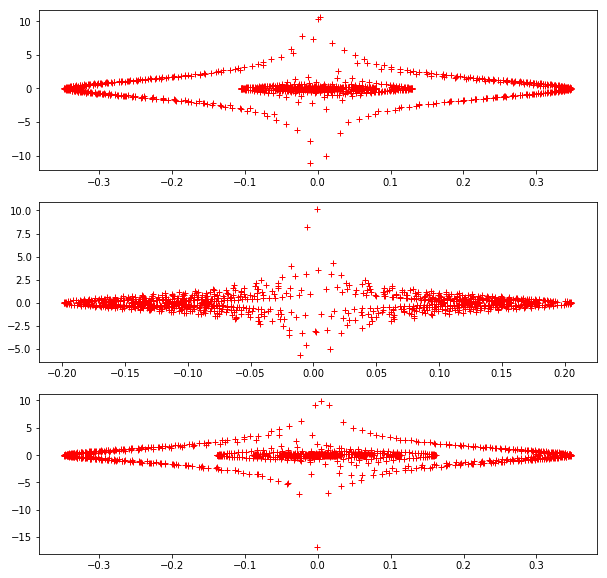

In [96]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(xtraj[:,d,n,0], ytraj[:,d,n,0],'r+')
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        #plt.xlim(-10, 10)
        #plt.ylim(-10, 10)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
#        plt.gca().set_aspect('equal', adjustable='box')